# MARATÓN BEHIND THE CODE 2020

# DESAFÍO 8 - Digital House

The challenge is to find out the employability of DH's users after they have finished one of their courses, to measure how much time it takes for a student to find a job.

<a href = "https://maratona.dev/es" target = "_blank">Link to the Maratona's site</a>

<a href = "https://github.com/maratonadev-la/desafio-8-2020" target = "_blank">Link to github of 8th challenge</a>

<a href = "https://maratona.dev/es/ranking?c=8" target = "_blank">Link to 8th challenge rankings (I finished 48th)</a>
<hr>

## Installing some useful python libraries

In [1]:
!pip install scikit-learn --upgrade
!pip install scipy --upgrade

Requirement already up-to-date: scikit-learn in c:\users\labra\appdata\local\programs\python\python36\lib\site-packages (0.23.2)
Requirement already up-to-date: scipy in c:\users\labra\appdata\local\programs\python\python36\lib\site-packages (1.5.4)


## Auxiliar Functions
First I defined some useful functions used for the project. I'm basically testing the model after changes to the data.

In [2]:
#Print some metrics
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score,mean_squared_error, r2_score

def model_metrics(y_test,y_pred):   #Calculate some metrics for the model
    mse = mean_squared_error(y_test,y_pred)
    print("Mean squared error: %.4f"
      % mse)
    #r2 = r2_score(y_test, y_pred)
    #print('R2 score: %.4f' % r2 )
    rmse = mse/2
    print('RMSE score: %.4f' % rmse )


In [3]:
#Since this is a regression problem, we'll use an LR predictor inside a function for easy testing the changes
#It just tests the basic LinearRegression model on demand
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

def test_lineal_regression(features, target, model = LinearRegression()):
    #Divide the data set for testing
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state = 133)

    #Create and fit basic LR model
    model = model.fit(X_train, y_train)
    scores=cross_val_score(model,X_train,y_train,cv=5,n_jobs=-1)

    #Evaluate model
    y_pred = model.predict(X_test)
    #print(str(len(model.coef_))+" features: "+ str(model.coef_))
    print("Cross Val R2 Score: "+ str(scores.mean().round(4)))
    model_metrics(y_test, y_pred)


In [4]:
##Helper OneHotEncoder that I found somewhere on the web

from sklearn.preprocessing import OneHotEncoder as SklearnOneHotEncoder

class OneHotEncoder(SklearnOneHotEncoder):
    def __init__(self, **kwargs):
        super(OneHotEncoder, self).__init__(**kwargs)
        self.fit_flag = False

    def fit(self, X, **kwargs):
        out = super().fit(X)
        self.fit_flag = True
        return out

    def transform(self, X, **kwargs):
        sparse_matrix = super(OneHotEncoder, self).transform(X)
        new_columns = self.get_new_columns(X=X)
        d_out = pd.DataFrame(sparse_matrix.toarray(), columns=new_columns, index=X.index)
        return d_out

    def fit_transform(self, X, **kwargs):
        self.fit(X)
        return self.transform(X)

    def get_new_columns(self, X):
        new_columns = []
        for i, column in enumerate(X.columns):
            j = 0
            while j < len(self.categories_[i]):
                new_columns.append(f'{column}_<{self.categories_[i][j]}>')
                j += 1
        return new_columns


<hr>

## Downloading the dataset from the internet and loading it to the notebook .csv

In [6]:
#!wget --no-check-certificate --content-disposition https://raw.githubusercontent.com/vanderlei-test/654986294958/master/train_dataset_digitalhouse.csv
df_training_dataset = pd.read_csv(r'train_dataset_digitalhouse.csv')
df_training_dataset.head()

,Unnamed: 0,EDAD,GENERO,RESIDENCIA,NV_ESTUDIO,ESTUDIO_PREV,TRACK_DH,AVG_DH,MINUTES_DH,EXPERIENCIA,DIAS_EMP
0,1000,37.0,FEMENINO,BRAZIL,UNIVERSITARY,NaN,PROGRAMACION,3.1,4131.5,21.3,97.0
1,1001,40.0,FEMENINO,NaN,UNIVERSITARY,COMMERCIAL,PROGRAMACION,3.1,4160.4,25.2,102.0
2,1002,35.0,NaN,ARGENTINA,UNIVERSITARY,DEVELOPMENT,DATA,3.1,4087.6,18.0,89.0
3,1003,33.0,FEMENINO,BRAZIL,UNIVERSITARY,ENGINEERING,NaN,3.1,4043.2,13.6,96.0
4,1004,29.0,NaN,BRAZIL,UNIVERSITARY,DEVELOPMENT,NaN,3.6,4688.0,NaN,83.0


In [7]:
df_training_dataset.shape

(8995, 11)

## We have the following columns in the dataset:

* Unnamed: 0
* EDAD
* GENERO
* RESIDENCIA
* NV_ESTUDIO
* ESTUDIO_PREV
* TRACK_DH
* AVG_DH
* MINUTES_DH
* EXPERIENCIA
* **DIAS_EMP = "target" value to be predicted**

In [8]:
df_training_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8995 entries, 0 to 8994
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    8995 non-null   int64  
 1   EDAD          7668 non-null   float64
 2   GENERO        7620 non-null   object 
 3   RESIDENCIA    7638 non-null   object 
 4   NV_ESTUDIO    7623 non-null   object 
 5   ESTUDIO_PREV  7665 non-null   object 
 6   TRACK_DH      7714 non-null   object 
 7   AVG_DH        7651 non-null   float64
 8   MINUTES_DH    7619 non-null   float64
 9   EXPERIENCIA   7618 non-null   float64
 10  DIAS_EMP      8995 non-null   float64
dtypes: float64(5), int64(1), object(5)
memory usage: 773.1+ KB


## Some things we need to consider:

1. Handle missing values

2. Handle categorical variables

<hr>


### Exploring columns with missing data

In [9]:
#Check how many rows with X missing features
nulls = np.zeros(len(df_training_dataset.columns))
for i in range(len(df_training_dataset.index)) :
    n = df_training_dataset.iloc[i].isnull().sum()
    nulls[n]+=1
for i in range(len(nulls)):
    print("There are "+str(nulls[i])+" rows with "+str(i)+" nulls")

There are 2125.0 rows with 0 nulls
There are 3279.0 rows with 1 nulls
There are 2294.0 rows with 2 nulls
There are 980.0 rows with 3 nulls
There are 265.0 rows with 4 nulls
There are 41.0 rows with 5 nulls
There are 10.0 rows with 6 nulls
There are 1.0 rows with 7 nulls
There are 0.0 rows with 8 nulls
There are 0.0 rows with 9 nulls
There are 0.0 rows with 10 nulls


In [10]:
#Removing useless id column
columns=['Unnamed: 0']
df_training_dataset_1 = df_training_dataset.drop(columns=columns, inplace=False)
df_training_dataset_1.tail()

,EDAD,GENERO,RESIDENCIA,NV_ESTUDIO,ESTUDIO_PREV,TRACK_DH,AVG_DH,MINUTES_DH,EXPERIENCIA,DIAS_EMP
8990,29.0,MASCULINO,ARGENTINA,TERTIARY,DEVELOPMENT,NaN,4.0,4701.6,9.1,86.0
8991,34.0,NaN,ARGENTINA,UNIVERSITARY,ENGINEERING,PROGRAMACION,3.4,4646.2,16.8,95.0
8992,28.0,FEMENINO,ARGENTINA,POST_GRADUATE,ENGINEERING,EJECUTIVO,NaN,3315.1,5.6,95.0
8993,23.0,MASCULINO,MEXICO,TERTIARY,ENGINEERING,PROGRAMACION,3.3,4437.8,0.9,87.0
8994,36.0,MASCULINO,ARGENTINA,UNIVERSITARY,COMMERCIAL,DATA,3.4,4600.8,19.6,88.0


## DATA EXPLORATION

Some things to consider when doing exploratory data analysis:
    <ul>
        <li>Look for variables that may help predict the target</li>
        <li>Look for correlations between variables that may help identify a strategy to impute missing values</li>
    </ul>

### Visualize numerical data

Before we do any imputation we need to visualize it to identify any patterns that may be hidden in the data, so we can then come up with an effective way to impute the missing data

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

num_features = ["EDAD", "AVG_DH", "MINUTES_DH", "EXPERIENCIA", "DIAS_EMP"]
cat_features = ["GENERO", "NV_ESTUDIO", "ESTUDIO_PREV", "TRACK_DH", "RESIDENCIA"]
target = "DIAS_EMP"
df_training_dataset_1[num_features].corr()

,EDAD,AVG_DH,MINUTES_DH,EXPERIENCIA,DIAS_EMP
EDAD,1.000000,0.007860,-0.008441,0.986745,0.414583
AVG_DH,0.007860,1.000000,0.863842,0.016897,-0.065931
MINUTES_DH,-0.008441,0.863842,1.000000,0.004918,-0.079498
EXPERIENCIA,0.986745,0.016897,0.004918,1.000000,0.416221
DIAS_EMP,0.414583,-0.065931,-0.079498,0.416221,1.000000


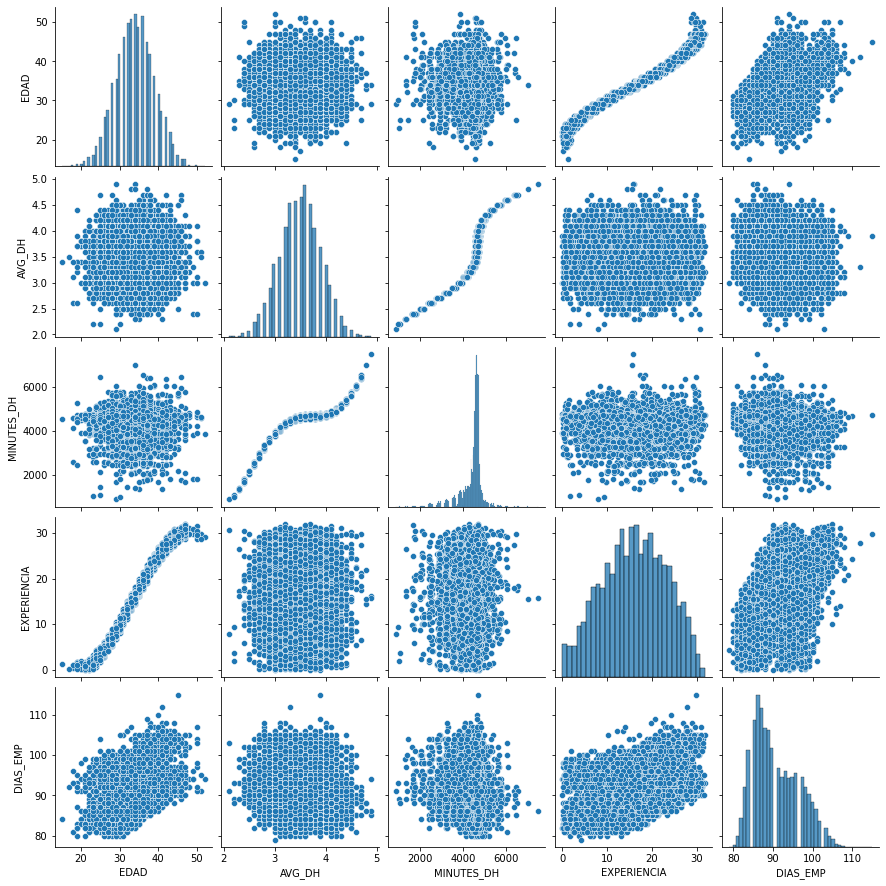

In [12]:
sns.pairplot(df_training_dataset_1)

In [19]:
df_training_dataset_1.describe() #Describe the data

,EDAD,AVG_DH,MINUTES_DH,EXPERIENCIA,DIAS_EMP
count,7668.000000,7651.000000,7619.000000,7618.000000,8995.000000
mean,33.989176,3.503228,4419.936461,16.112497,90.807449
std,5.024501,0.404276,524.528119,7.154829,5.675932
min,15.000000,2.100000,889.300000,0.000000,79.000000
25%,31.000000,3.200000,4345.850000,10.825000,86.000000
50%,34.000000,3.500000,4575.300000,16.200000,90.000000
75%,37.000000,3.800000,4676.100000,21.600000,95.000000
max,52.000000,4.900000,7466.500000,31.900000,115.000000


Some observations:
    <ul>
    <li>Most features already normally distributed, so we may not need to deal with that.</li>
    <li>There's a clear relationship between the column pairs [EDAD, EXPERIENCIA] and [MINUTES_DH, AVG_DH], which suggests we may be able to find a non-linear function that describes one parameter given the other one</li>
    <li>Although MINUTES_DH and AVG_DH are correlated, they both have a low correlation with the target variable, so dropping them may be worth considering</li>
    </ul>


### Visualizing categorical data

We start by using countplots with our categorical data

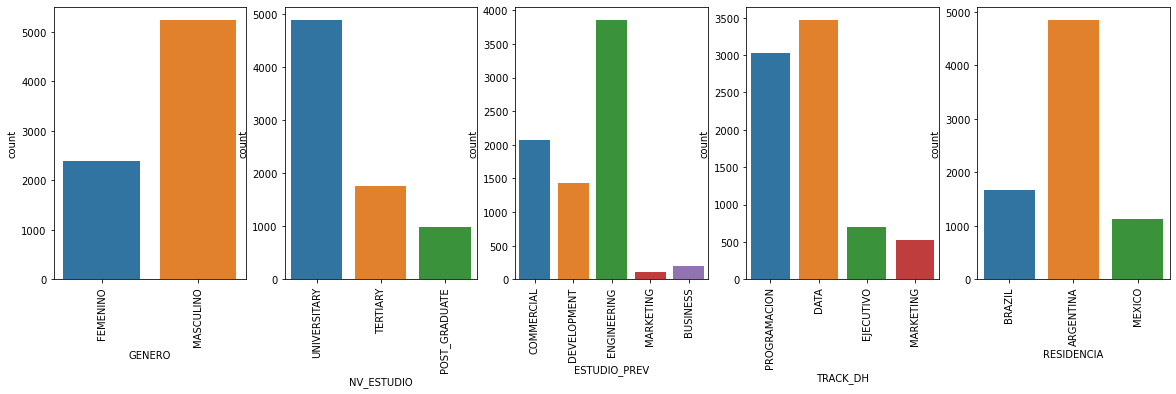

In [14]:
fig, ax = plt.subplots(1, 5, figsize=(20, 5))
for variable, subplot in zip(cat_features, ax.flatten()):
    sns.countplot(data = df_training_dataset_1, x = variable, ax=subplot)
    for label in subplot.get_xticklabels():
        label.set_rotation(90)

We now study how the feature varies across the different categories

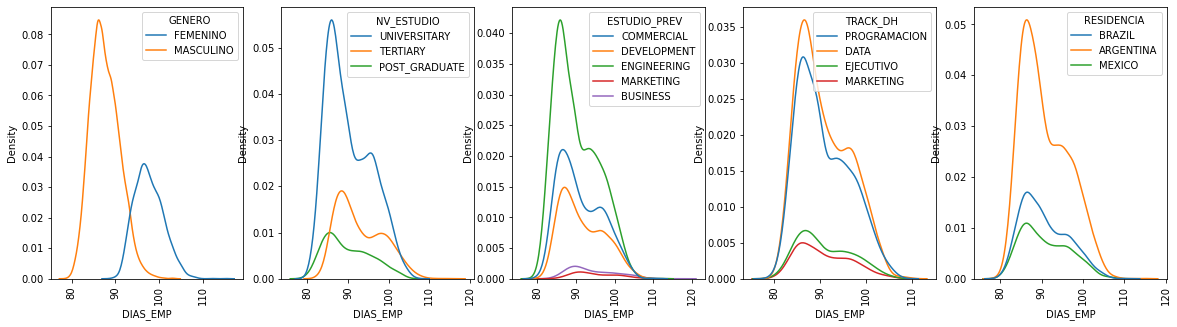

In [15]:
fig, ax = plt.subplots(1, 5, figsize=(20, 5))
for variable, subplot in zip(cat_features, ax.flatten()):
    sns.kdeplot(data = df_training_dataset_1, x = target, ax=subplot, hue = variable)
    for label in subplot.get_xticklabels():
        label.set_rotation(90)

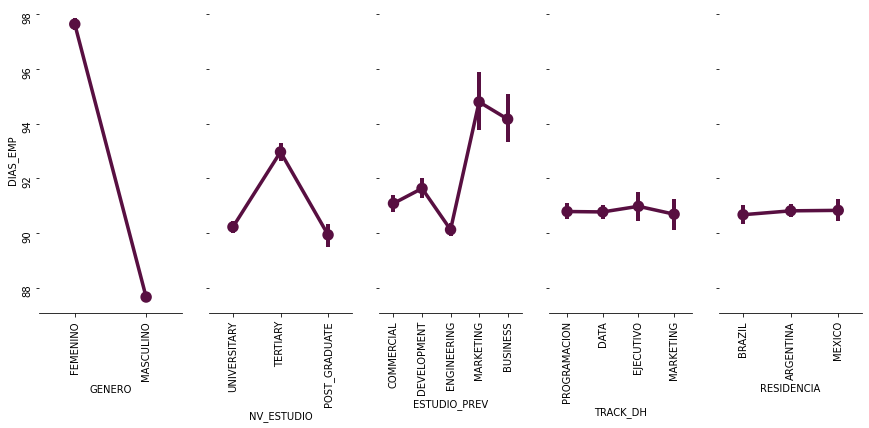

In [16]:
# Set up a grid to plot survival probability against several variables
g = sns.PairGrid(df_training_dataset_1, y_vars="DIAS_EMP",
                 x_vars= cat_features,
                 height=5, aspect=.5)
# Draw a seaborn pointplot onto each Axes
g.map(sns.pointplot, scale=1.3, errwidth=4, color="xkcd:plum")
sns.despine(fig=g.fig, left=True)
for ax in g.axes.flatten():
    ax.tick_params(rotation = 90)


Some observations:
<ul>
    <li> The target varies greatly across categories from "GENERO", "NV_ESTUDIO", "ESTUDIO_PREV"</li>
    <li> The target varies very slightly under "RESIDENCIA" and "TRACK_DH", so we will drop them</li>
</ul>

In [17]:
df_training_dataset_1.drop(columns = ["RESIDENCIA", "TRACK_DH"], inplace = True)

## Imputing missing values
The danger of dropping missing values is that our model may not learn all the features properly.
When we impute missing values we must be careful not to greatly disbalance the dataset

Let's see how many rows we're getting rid of if we just drop any row with nulls:

In [18]:
df_training_dataset_1.dropna().shape

(2863, 8)


### Imputing categorical 

The most popular ways of imputing categorical values are 
<ul>
<li>filling it with the most frequent one</li>
<li>filling it with another category</li>
<li>predict it based on other variables</li>
</ul>

We're going to try the first two strategies, plot them to visualize results and try an early LR to check performance.
Let's first run LR with the categorical variables but dropping all na values to see the performance we could be looking up to.

In [22]:
#First trainning without any missing data

#from sklearn.preprocessing import OneHotEncoder
cat_features = ["GENERO", "NV_ESTUDIO", "ESTUDIO_PREV"]

df_cat_impute = df_training_dataset_1[cat_features].copy()
df_cat_impute[target] = df_training_dataset_1[target]
df_cat_dropna = df_cat_impute.dropna()
cat_dropna_target = df_cat_dropna[target]
df_cat_dropna = df_cat_dropna.dropna()
df_cat_dropna = df_cat_dropna.drop(columns = target)
#df_cat_dropna2 = OneHotEncoder().fit_transform(df_cat_dropna["GENERO"].values.reshape(-1,1))
df_cat_dropna2 = OneHotEncoder().fit_transform(df_cat_dropna)
test_lineal_regression(df_cat_dropna2, cat_dropna_target)

Cross Val R2 Score: 0.7339
Mean squared error: 8.5234
RMSE score: 4.2617


In [23]:
#Now fill with most frequent

from sklearn.impute import SimpleImputer
cat_imputer = SimpleImputer(strategy = "most_frequent")
df_cat_impute2 = pd.DataFrame(
    data = cat_imputer.fit_transform(df_cat_impute),
    columns = df_cat_impute.columns
)
df_cat_impute2.head()

,GENERO,NV_ESTUDIO,ESTUDIO_PREV,DIAS_EMP
0,FEMENINO,UNIVERSITARY,ENGINEERING,97
1,FEMENINO,UNIVERSITARY,COMMERCIAL,102
2,MASCULINO,UNIVERSITARY,DEVELOPMENT,89
3,FEMENINO,UNIVERSITARY,ENGINEERING,96
4,MASCULINO,UNIVERSITARY,DEVELOPMENT,83


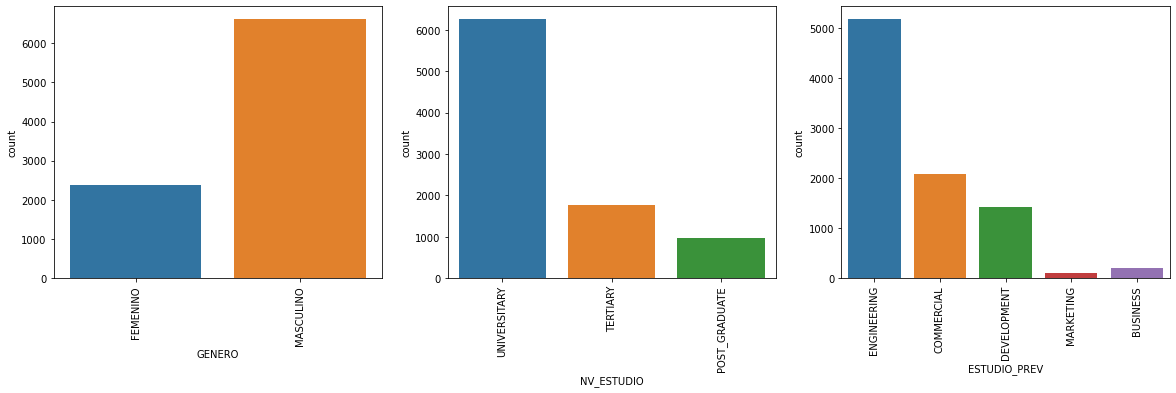

In [24]:
# Set up a grid to plot survival probability against several variables
df_cat_impute2[target] = df_training_dataset_1[target]

fig, ax = plt.subplots(1, 3, figsize=(20, 5))
for variable, subplot in zip(cat_features, ax.flatten()):
    sns.countplot(data = df_cat_impute2, x = variable, ax=subplot)
    for label in subplot.get_xticklabels():
        label.set_rotation(90)

Let's try and train this one

In [26]:
df_cat_impute3 = df_cat_impute2.drop(columns = [target])
df_cat_impute3 = OneHotEncoder().fit_transform(df_cat_impute3)
test_lineal_regression(df_cat_impute3, df_training_dataset_1[target])

Cross Val R2 Score: 0.5737
Mean squared error: 13.2366
RMSE score: 6.6183


So we've gotten a difference of -0.16, a really big one considering we have almost half of the dataset with at least one value that was filled.
Let's now try with imputing by creating another category among the variables. (ex. "GENERO" would now have ["FEMENINO", "MASCULINO", "MISSING"]) as its values

In [27]:
#Now fill with "missing values"
df_cat_impute = df_training_dataset_1[cat_features].copy()
miss_imputer = SimpleImputer(strategy="constant", fill_value="MISSING")
df_inputed_missing = pd.DataFrame(data= miss_imputer.fit_transform(df_cat_impute), columns = cat_features)
df_inputed_missing_encoded = OneHotEncoder().fit_transform(df_inputed_missing)
test_lineal_regression( df_inputed_missing_encoded, df_training_dataset_1[target])

Cross Val R2 Score: 0.618
Mean squared error: 12.2891
RMSE score: 6.1445


Now we have a -0.12 difference, still a big one but this is clearly the superior one compared to filling with  that we tried, so we're gonna stick with this one

### Imputing numerical values

There are multiple strategies we can try, for exapmle:
<ul>
    <li>Fill with Mean
    <li>Fill with Median
    <li>Fill with Mode
    <li>Predict them
</ul>

As before, we're going to try train a model without any missing values to have a starting comparison, then we'll try the different strategies described above

In [28]:
#Try predict without any missing value for numerical features
df_num_impute = df_training_dataset_1[num_features].dropna().copy()
num_impute_target = df_num_impute[target]
df_num_impute.drop(columns=[target], inplace=True)
test_lineal_regression(df_num_impute, num_impute_target)

Cross Val R2 Score: 0.182
Mean squared error: 26.1434
RMSE score: 13.0717


So far a very poor performance, which we'll improve definitely once we mix the categorical features with the numerical ones.
Now we try the different approaches, visualize the effects on the dataset and train

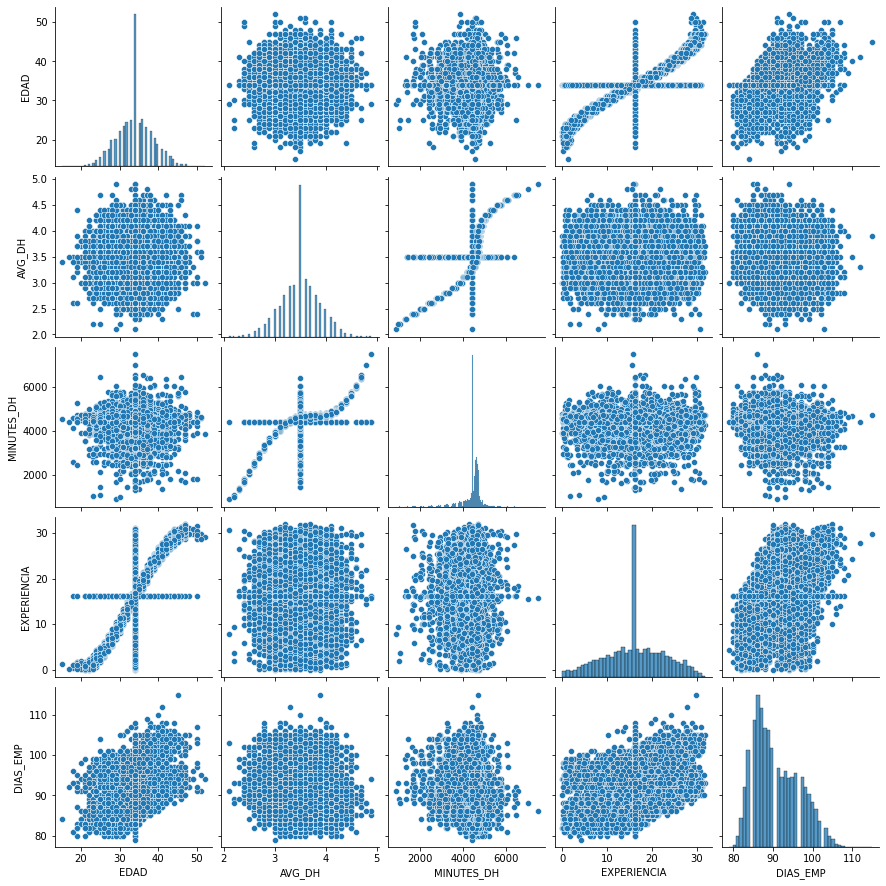

In [29]:
#Fill missing numeric features with with mean values
df_num_impute = df_training_dataset_1[num_features].copy()
mean_imputer = SimpleImputer(strategy="mean")
df_num_impute = pd.DataFrame(data = mean_imputer.fit_transform(df_num_impute), columns = num_features)
sns.pairplot(df_num_impute)

By looking at the distribution plots and the plots between the pairs [EDAD, EXPERIENCIA] and [MINUTES_DH, AVG_DH] we can see that we're doing something wrong, the existing patterns are clearly disrupted. This was done only by substituting by the mean, we see that if we substitute by any constant, as it would be done by using the mode or meadian, we'll get a similar result. Let's find the performance for this one

In [31]:
num_mean_target = df_num_impute[target]
df_num_impute2 = df_num_impute.drop(columns = [target])
test_lineal_regression(df_num_impute2, df_training_dataset_1[target])

Cross Val R2 Score: 0.16
Mean squared error: 27.0971
RMSE score: 13.5485


A difference of -0.022, not so big but let's see what the other strategies offer. Since we've seen the effect of filling a constant let's jump straight to training them.

In [32]:
#fill with constants for mode and median
df_num_impute = df_training_dataset_1[num_features].copy()
mode_imputer = SimpleImputer(strategy="most_frequent")
median_imputer = SimpleImputer(strategy="median")
df_num_impute_mode = pd.DataFrame(data = mode_imputer.fit_transform(df_num_impute), columns = num_features)
df_num_impute_median = pd.DataFrame(data = median_imputer.fit_transform(df_num_impute), columns = num_features)
df_num_impute_median2 = df_num_impute_median.drop(columns = [target])
df_num_impute_mode2 = df_num_impute_mode.drop(columns = [target])
print("MODE: ")
test_lineal_regression(df_num_impute_mode2, df_training_dataset_1[target])
print("MEDIAN: ")
test_lineal_regression(df_num_impute_median2, df_training_dataset_1[target])

MODE: 
Cross Val R2 Score: 0.1595
Mean squared error: 27.0820
RMSE score: 13.5410
MEDIAN: 
Cross Val R2 Score: 0.1598
Mean squared error: 27.0864
RMSE score: 13.5432


A somewhat similar performance compared to filling with mean.

Let's try by using a predictor, in this case scikit's KNN Imputer. Since the pairs ["EDAD","EXPERIENCIA"] and ["MINUTES_DH","AVG_DH"] only have a high correlation with each other, we're going to predict only between those two.

In [33]:
#fill with imputer
from sklearn.impute import KNNImputer
imputer = KNNImputer()
cols_to_impute = ["EDAD","EXPERIENCIA"]
df_edad_exp_filled_knn1 = pd.DataFrame(data = imputer.fit_transform(df_training_dataset_1[cols_to_impute]), columns = cols_to_impute)
cols_to_impute = ["MINUTES_DH","AVG_DH"]
df_dh_filled_knn2 = pd.DataFrame(data = imputer.fit_transform(df_training_dataset_1[cols_to_impute]), columns = cols_to_impute)
df_knn = df_edad_exp_filled_knn1.join(df_dh_filled_knn2)
df_knn.head()

,EDAD,EXPERIENCIA,MINUTES_DH,AVG_DH
0,37.0,21.30,4131.5,3.1
1,40.0,25.20,4160.4,3.1
2,35.0,18.00,4087.6,3.1
3,33.0,13.60,4043.2,3.1
4,29.0,8.62,4688.0,3.6


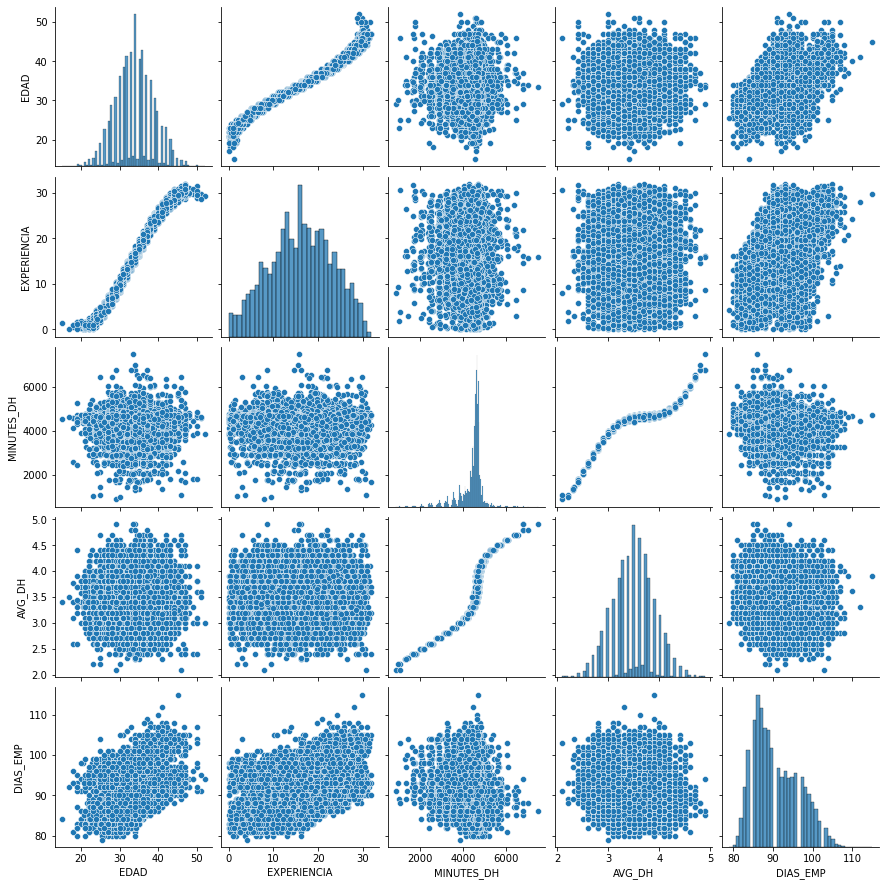

In [34]:
df_knn[target] = df_training_dataset_1[target]
sns.pairplot(df_knn)

Now the plots don't show weird effects, as the missing values were predicted. Let's see it's performance

In [36]:
df_knn2 = df_knn.drop(columns = [target])
test_lineal_regression(df_knn2, df_training_dataset_1[target])

Cross Val R2 Score: 0.1689
Mean squared error: 26.6045
RMSE score: 13.3023


Now we have seen an improvement of +0.009 over the previous approaches.
We proceed to do some feature transformations.

## Feature Engineering

Here we apply some transformations over the numeric data in an attempt to improve performance.
We have seen the relationship between EDAD-EXPERIENCIA and MINUTES_DH-AVG_DH, both of them appear to apply a polynomial Transformation, which we can clearly see using a regplot

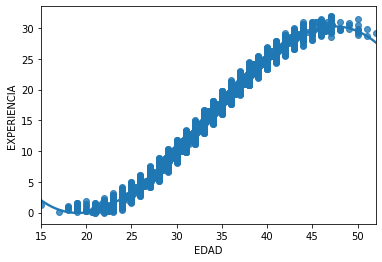

In [37]:
sns.regplot(x='EDAD', y='EXPERIENCIA', order=3, data=df_knn2)

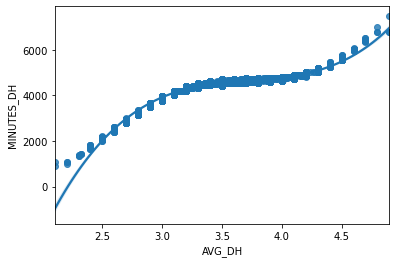

In [40]:
sns.regplot(x='AVG_DH', y='MINUTES_DH', order=3, data=df_knn2) 

We can simulate this effect with scikit's PolynomialFeatures, using a degree of 3 respectively, however we must do them separately, since we are not using "EDAD" to predict "MINUTES_DH", for example.
Since this is the final transformation we also scale the numeric features

In [43]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

df_knn_imputed = df_knn2.copy()

df_knn_imputed = pd.DataFrame(StandardScaler().fit_transform(df_knn_imputed),columns = df_knn_imputed.columns)
df_knn_imputed_1 = pd.DataFrame(PolynomialFeatures(degree = 3).fit_transform(df_knn_imputed[["EDAD", "EXPERIENCIA"]]))
df_knn_imputed_2 = pd.DataFrame(PolynomialFeatures(degree = 3).fit_transform(df_knn_imputed[[ "MINUTES_DH", "AVG_DH"]]))
df_knn_imputed = df_knn_imputed_2.join(df_knn_imputed_1, rsuffix = "E-")

df_knn_imputed.head()

,0,1,2,3,4,5,6,7,8,9,0E-,1E-,2E-,3E-,4E-,5E-,6E-,7E-,8E-,9E-
0,1.0,-0.554091,-0.999530,0.307017,0.553831,0.999060,-0.170116,-0.306873,-0.553570,-0.998590,1.0,0.611488,0.739342,0.373918,0.452099,0.546627,0.228646,0.276453,0.334256,0.404144
1,1.0,-0.498773,-0.999530,0.248774,0.498538,0.999060,-0.124082,-0.248657,-0.498304,-0.998590,1.0,1.217002,1.293692,1.481093,1.574425,1.673639,1.802493,1.916079,2.036821,2.165173
2,1.0,-0.638122,-0.999530,0.407200,0.637822,0.999060,-0.259843,-0.407008,-0.637522,-0.998590,1.0,0.207813,0.270277,0.043186,0.056167,0.073050,0.008975,0.011672,0.015181,0.019744
3,1.0,-0.723110,-0.999530,0.522888,0.722770,0.999060,-0.378106,-0.522642,-0.722430,-0.998590,1.0,-0.195863,-0.355143,0.038362,0.069559,0.126127,-0.007514,-0.013624,-0.024704,-0.044793
4,1.0,0.511129,0.252392,0.261253,0.129005,0.063702,0.133534,0.065938,0.032560,0.016078,1.0,-1.003214,-1.063005,1.006439,1.066422,1.129980,-1.009674,-1.069850,-1.133613,-1.201175


In [44]:
test_lineal_regression(df_knn_imputed, df_training_dataset_1[target])

Cross Val R2 Score: 0.1766
Mean squared error: 26.1464
RMSE score: 13.0732


With Polynomial Features we now have an improvement of +0.07 over pure imputations

Now we join the datasets with categorical and numerical features to see how it performs with all the improvements done.

In [45]:
df_full = df_knn_imputed.join(df_inputed_missing_encoded)
test_lineal_regression(df_full, df_training_dataset_1[target])

Cross Val R2 Score: 0.8122
Mean squared error: 5.7783
RMSE score: 2.8892


## Model Exploration

Here we will use different scikit models for regression and compare them, then we also use our own custom LR model to compare

In [46]:
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn import svm
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

mlp = MLPRegressor()
regr = RandomForestRegressor()
svm = svm.SVR()
en = ElasticNet(random_state = 0)
lasso = Lasso()
r = Ridge()
models = [mlp,regr,svm,en,lasso,r, LinearRegression()]


for m in models:
    print("------------")
    print(m)
    test_lineal_regression(df_full, df_training_dataset_1[target], model = m)

------------
MLPRegressor()
Cross Val R2 Score: 0.7935
Mean squared error: 6.2586
RMSE score: 3.1293
------------
RandomForestRegressor()
Cross Val R2 Score: 0.7724
Mean squared error: 6.9463
RMSE score: 3.4731
------------
SVR()
Cross Val R2 Score: 0.6962
Mean squared error: 8.7795
RMSE score: 4.3897
------------
ElasticNet(random_state=0)
Cross Val R2 Score: 0.4279
Mean squared error: 18.2973
RMSE score: 9.1486
------------
Lasso()
Cross Val R2 Score: 0.4991
Mean squared error: 16.0018
RMSE score: 8.0009
------------
Ridge()
Cross Val R2 Score: 0.8121
Mean squared error: 5.7720
RMSE score: 2.8860
------------
LinearRegression()
Cross Val R2 Score: 0.8122
Mean squared error: 5.7783
RMSE score: 2.8892


So from all the models seen the basic LinearRegression() and Ridge() linear models are the strongest ones, let's further analyze the Ridge model by tuning its hyperparameters. We'll use the r2 scoring.


In [47]:
from sklearn.model_selection import GridSearchCV
params_Ridge = {'alpha': [100,10,1,0.1,0.01,0.001,0.0001,0], 
                "fit_intercept": [True, False], 
                "solver": ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],
                "tol": [0.01, 0.005, 0.001, 0.005, 0.0001]
               }
Ridge_GS = GridSearchCV( Ridge(), param_grid = params_Ridge, n_jobs = -1, cv = 5, scoring = 'r2')
Ridge_GS.fit(df_full, df_training_dataset_1[target])
df_results = pd.DataFrame(Ridge_GS.cv_results_)


In [48]:
df_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_fit_intercept,param_solver,param_tol,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.137258,0.033842,0.012248,0.002539,100,True,svd,0.01,"{'alpha': 100, 'fit_intercept': True, 'solver'...",0.821221,0.814549,0.806576,0.805717,0.811619,0.811937,0.005667,215
1,0.090616,0.018079,0.019248,0.009559,100,True,svd,0.005,"{'alpha': 100, 'fit_intercept': True, 'solver'...",0.821221,0.814549,0.806576,0.805717,0.811619,0.811937,0.005667,215
2,0.090664,0.039953,0.012298,0.000722,100,True,svd,0.001,"{'alpha': 100, 'fit_intercept': True, 'solver'...",0.821221,0.814549,0.806576,0.805717,0.811619,0.811937,0.005667,215
3,0.090322,0.019617,0.014665,0.008322,100,True,svd,0.005,"{'alpha': 100, 'fit_intercept': True, 'solver'...",0.821221,0.814549,0.806576,0.805717,0.811619,0.811937,0.005667,215
4,0.086210,0.029392,0.023480,0.019199,100,True,svd,0.0001,"{'alpha': 100, 'fit_intercept': True, 'solver'...",0.821221,0.814549,0.806576,0.805717,0.811619,0.811937,0.005667,215


Now we select and display the top 15 parameter combinations

In [49]:
pd.set_option('display.max_rows', 500)

df_results2 = df_results[["param_alpha", "param_fit_intercept", "param_solver", "param_tol", "mean_test_score", "std_test_score", "rank_test_score"]]
df_results2.sort_values(["rank_test_score"]).head(15)

,param_alpha,param_fit_intercept,param_solver,param_tol,mean_test_score,std_test_score,rank_test_score
139,1,True,sparse_cg,0.0001,0.815740,0.006067,1
439,0,True,sparse_cg,0.0001,0.815733,0.006068,2
199,0.1,True,sparse_cg,0.0001,0.815731,0.006063,3
259,0.01,True,sparse_cg,0.0001,0.815730,0.006063,4
319,0.001,True,sparse_cg,0.0001,0.815730,0.006063,5
379,0.0001,True,sparse_cg,0.0001,0.815730,0.006063,6
129,1,True,cholesky,0.0001,0.815695,0.006050,7
128,1,True,cholesky,0.005,0.815695,0.006050,7
125,1,True,cholesky,0.01,0.815695,0.006050,7
126,1,True,cholesky,0.005,0.815695,0.006050,7


A high mean test score means the model accounts for higher percentage of the dataset, a low std test score means it's unlikely to be overfitting

In [50]:
print("Best score: ")
Ridge_GS.best_score_

Best score: 


0.8157402587972623

In [51]:
print("Best params: ")
Ridge_GS.best_params_

Best params: 


{'alpha': 1, 'fit_intercept': True, 'solver': 'sparse_cg', 'tol': 0.0001}

Now that we got the best hyperparameters for our model let's see some other metrics and visualize some results

In [52]:
X_train, X_test, y_train, y_test = train_test_split(df_full, df_training_dataset_1[target], test_size=0.25, random_state = 133)
model = Ridge(**Ridge_GS.best_params_).fit(X_train, y_train)
y_pred = model.predict(X_test)
model_metrics(y_test, y_pred)


Mean squared error: 5.7713
RMSE score: 2.8856


Now let's graph some results to compare the predictions vs the actual values

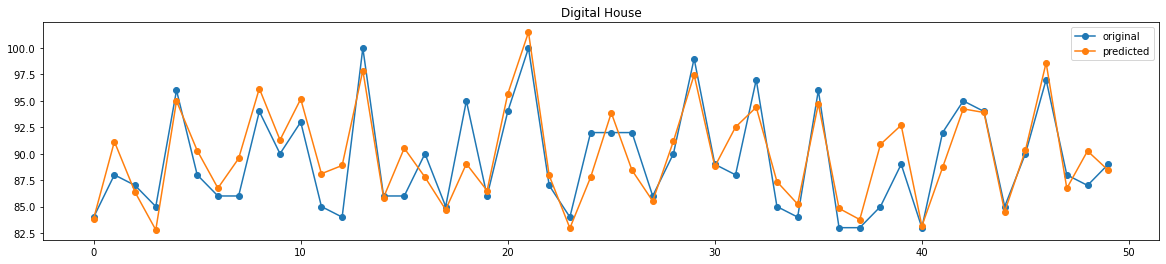

In [53]:
import matplotlib.pyplot as plt

inicio = 0
cant = 50
y = y_test[inicio:inicio + cant]
y_p = y_pred[inicio:inicio + cant]

x_ax = range(len(y))
plt.figure(figsize=(20, 4))
plt.plot(x_ax, y, label="original",marker='o')
plt.plot(x_ax, y_p, label="predicted",marker='o')
plt.title("Digital House")
plt.legend()
plt.show()


### Custom LR model

In [54]:
class LinearRegressionByHand():

    def __init__(self, learning_rate = 0.0001, iterations = 10000):
        self.learning_rate = learning_rate
        self.iterations = iterations
        
    def compute_loss(self, y, y_true):
        loss = np.sum(np.square(y - y_true))
        return loss / ( 2 * self.m)

    
    def predict(self, X):  #return y = b + w1x1 + w2x2 + ... + wnxn
        y = self.b + np.dot(X, self.W)
        return y

        
    def gd(self, X, y_true, y_hat):   #Compute the derivatives from the loss function
        db = np.sum(y_hat - y_true) / self.m
        dW = np.sum(np.dot(np.transpose(y_hat - y_true), X), axis=0)/ self.m
        return dW, db

    
    def update_params(self, dW, db):
        self.W = self.W - self.learning_rate * np.reshape(dW, (self.n, 1))
        self.b = self.b - self.learning_rate * db


    def fit(self, x_train, y_train):
        y_train = y_train.values.reshape(-1,1)
        self.m, self.n = x_train.shape # m is # of rows. n is # of features
        self.W = np.random.randn(self.n, 1) # params
        self.b = np.random.randn() # bias
        losses = []
        for i in range(self.iterations):
            y_hat = self.predict(x_train)
            loss = self.compute_loss(y_hat, y_train)            
            dW, db = self.gd(x_train, y_train, y_hat) 
            self.update_params(dW, db)  
            losses.append(loss)
        return losses


In [55]:
#from LRByHand import LinearRegressionByHand
import numpy as np

columns = ["ITERATIONS", "LEARNING_RATE", "R2", "MSE"]
results = pd.DataFrame()
iterations = [1000, 10000, 100000]
learning_rates = [10e-4, 10e-5, 10e-6]

for i in iterations:
    for lr in learning_rates:
        print("Training iter " + str(i) + " alpha " + str(lr))
        model = LinearRegressionByHand(iterations = i, learning_rate = lr)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        r2, mse = r2_score(y_test, y_pred), mean_squared_error(y_test, y_pred)
        results = results.append([[i, lr, r2, mse]])
        

Training iter 1000 alpha 0.001
Training iter 1000 alpha 0.0001
Training iter 1000 alpha 1e-05
Training iter 10000 alpha 0.001
Training iter 10000 alpha 0.0001
Training iter 10000 alpha 1e-05
Training iter 100000 alpha 0.001
Training iter 100000 alpha 0.0001
Training iter 100000 alpha 1e-05


In [56]:
results.columns = columns
results.sort_values(["R2"], ascending = False)

,ITERATIONS,LEARNING_RATE,R2,MSE
0,100000,0.00100,0.820629,5.870320
0,10000,0.00100,0.767703,7.602444
0,100000,0.00010,0.749963,8.183055
0,100000,0.00001,-3.229286,138.413193
0,10000,0.00010,-3.347178,142.271484
0,1000,0.00100,-3.595710,150.405269
0,10000,0.00001,-67.171730,2231.077925
0,1000,0.00010,-72.307377,2399.153870
0,1000,0.00001,-199.085569,6548.264141


## Deploying the model to IBM's Machine Learning Services

Now that we built the model we can use IBM's ML services to host our model and interact with it via an API, but first we need to use a pipeline that includes all changes that we have made throughout the notebook, in that order:
<ol>
    <li>Remove useless columns</li>
    <li>Impute missing values for categorical features with SimpleImputer</li>
    <li>One Hot Encode categorical features</li>
    <li>Standardize numerical features</li>
    <li>KNN impute values between "EDAD" and "EXPERIENCIA"</li>
    <li>KNN impute values between "MINUTES_DH" and "AVG_DH"</li>
    <li>Power Transform to 3 between "MINUTES_DH" and "AVG_DH"</li>
    <li>Power Transform to 3 "EDAD" and "EXPERIENCIA"</li>
    <li>Apply our selected model</li>
</ol>

In [76]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

numeric_features = ["EDAD", "EXPERIENCIA", "AVG_DH", "MINUTES_DH"]
categorical_features = ["GENERO", "NV_ESTUDIO", "ESTUDIO_PREV"]
numeric_for_knnimputer1 = [ "EDAD", "EXPERIENCIA"]
numeric_for_knnimputer2 = [ "AVG_DH", "MINUTES_DH"]


categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numeric_transformer1 = Pipeline(steps=[
    ('knn',KNNImputer()),
    ('scaler', StandardScaler()),
    ('power-transform', PolynomialFeatures(degree = 3))
])

numeric_transformer2 = Pipeline(steps=[
    ('knn2',KNNImputer()),
    ('scaler2', StandardScaler()),
    ('power-transform2', PolynomialFeatures(degree = 3))
])

preprocessor = ColumnTransformer(
    [
     ('ed_exp', numeric_transformer1, numeric_for_knnimputer1),
     ('min_avg', numeric_transformer2, numeric_for_knnimputer2),
     ('cat', categorical_transformer, categorical_features)
    ],
    remainder="drop")

model = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regressor', Ridge(**Ridge_GS.best_params_))])



Testing the preprocessor step

In [77]:
new_df = df_training_dataset.drop(columns = [target])
m1 = pd.DataFrame(preprocessor.fit_transform(new_df))

In [78]:
#m1.columns = ["EDAD", "EXPERIENCIA", "UNNAMED","GENERO","RESIDENCIA","NV_ESTUDIO","ESTUDIO_PREV","TRACK","AVG_DH","MINUTES_DH"]
m1.head()

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,1.0,0.611488,0.739342,0.373918,0.452099,0.546627,0.228646,0.276453,0.334256,0.404144,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.0,1.217002,1.293692,1.481093,1.574425,1.673639,1.802493,1.916079,2.036821,2.165173,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1.0,0.207813,0.270277,0.043186,0.056167,0.073050,0.008975,0.011672,0.015181,0.019744,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1.0,-0.195863,-0.355143,0.038362,0.069559,0.126127,-0.007514,-0.013624,-0.024704,-0.044793,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1.0,-1.003214,-1.063005,1.006439,1.066422,1.129980,-1.009674,-1.069850,-1.133613,-1.201175,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [79]:
df_training_dataset.head()

,Unnamed: 0,EDAD,GENERO,RESIDENCIA,NV_ESTUDIO,ESTUDIO_PREV,TRACK_DH,AVG_DH,MINUTES_DH,EXPERIENCIA,DIAS_EMP
0,1000,37.0,FEMENINO,BRAZIL,UNIVERSITARY,NaN,PROGRAMACION,3.1,4131.5,21.3,97.0
1,1001,40.0,FEMENINO,NaN,UNIVERSITARY,COMMERCIAL,PROGRAMACION,3.1,4160.4,25.2,102.0
2,1002,35.0,NaN,ARGENTINA,UNIVERSITARY,DEVELOPMENT,DATA,3.1,4087.6,18.0,89.0
3,1003,33.0,FEMENINO,BRAZIL,UNIVERSITARY,ENGINEERING,NaN,3.1,4043.2,13.6,96.0
4,1004,29.0,NaN,BRAZIL,UNIVERSITARY,DEVELOPMENT,NaN,3.6,4688.0,NaN,83.0


Testing that the pipeline is correct

In [80]:
y = df_training_dataset[target]
X = df_training_dataset.drop(target, axis=1)
model = model.fit(X, y)
model.score(X, y)

0.8170113950204283

In [81]:
predictions = model.predict(X)
model_metrics(y, predictions)

Mean squared error: 5.8945
RMSE score: 2.9473


The performance is comparable to the one with step-by-step transformations.
Now we will upload the model to IBM's services. Tutorial on how to do it:

In [64]:
#Install this library
!pip install ibm-watson-machine-learning

In [65]:
from ibm_watson_machine_learning import APIClient
api_key = "-G3U50xfvNeOz0d8uCTPDIUN2kdr3fTOz-fczYAZqcHb"
location = "us-south"


In [66]:
wml_credentials = {
    "apikey": api_key,
    "url": 'https://' + location + '.ml.cloud.ibm.com'
}
client = APIClient(wml_credentials)


DEPRECATED!! Python 3.6 framework is deprecated and will be removed on Jan 20th, 2021.It will be read-only mode starting Nov 20th, 2020. i.e you won't be able to create new assets using this client.Use Python 3.7 instead. For details, see https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/pm_service_supported_frameworks.html


In [67]:
client.spaces.list()

Note: 'limit' is not provided. Only first 50 records will be displayed if the number of records exceed 50
------------------------------------  ----------  ------------------------
ID                                    NAME        CREATED
bf9591f5-d734-4dcc-aa0f-5f715a3d5a5c  ml-project  2020-11-11T04:57:58.654Z
------------------------------------  ----------  ------------------------


In [68]:
client.set.default_space("bf9591f5-d734-4dcc-aa0f-5f715a3d5a5c")

'SUCCESS'

In [69]:
import sys
sys.version
import sklearn
sklearn.__version__

'0.23.2'

In [70]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

numeric_features = ["EDAD", "EXPERIENCIA", "AVG_DH", "MINUTES_DH"]
categorical_features = ["GENERO", "NV_ESTUDIO", "ESTUDIO_PREV"]
numeric_for_knnimputer1 = [ "EDAD", "EXPERIENCIA"]
numeric_for_knnimputer2 = [ "AVG_DH", "MINUTES_DH"]


categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numeric_transformer1 = Pipeline(steps=[
    ('knn',KNNImputer()),
    ('scaler', StandardScaler()),
    ('power-transform', PolynomialFeatures(degree = 3))
])

numeric_transformer2 = Pipeline(steps=[
    ('knn2',KNNImputer()),
    ('scaler2', StandardScaler()),
    ('power-transform2', PolynomialFeatures(degree = 4))
])

preprocessor = ColumnTransformer(
    [
     ('ed_exp', numeric_transformer1, numeric_for_knnimputer1),
     ('min_avg', numeric_transformer2, numeric_for_knnimputer2),
     ('cat', categorical_transformer, categorical_features)
    ],
    remainder="drop")

model = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regressor', Ridge(**Ridge_GS.best_params_))])

In [71]:
y = df_training_dataset["DIAS_EMP"]
X = df_training_dataset.drop("DIAS_EMP", axis=1)
model = model.fit(X, y)

In [72]:
model.score(X, y)

0.8171811038918915

In [73]:
predictions = model.predict(X)

In [74]:
model_metrics(y, predictions)

Mean squared error: 5.8891
RMSE score: 2.9445


In [75]:
client.software_specifications.list()

-----------------------------  ------------------------------------  ----
NAME                           ASSET_ID                              TYPE
default_py3.6                  0062b8c9-8b7d-44a0-a9b9-46c416adcbd9  base
pytorch-onnx_1.3-py3.7-edt     069ea134-3346-5748-b513-49120e15d288  base
scikit-learn_0.20-py3.6        09c5a1d0-9c1e-4473-a344-eb7b665ff687  base
spark-mllib_3.0-scala_2.12     09f4cff0-90a7-5899-b9ed-1ef348aebdee  base
ai-function_0.1-py3.6          0cdb0f1e-5376-4f4d-92dd-da3b69aa9bda  base
shiny-r3.6                     0e6e79df-875e-4f24-8ae9-62dcc2148306  base
pytorch_1.1-py3.6              10ac12d6-6b30-4ccd-8392-3e922c096a92  base
tensorflow_1.15-py3.6-ddl      111e41b3-de2d-5422-a4d6-bf776828c4b7  base
scikit-learn_0.22-py3.6        154010fa-5b3b-4ac1-82af-4d5ee5abbc85  base
default_r3.6                   1b70aec3-ab34-4b87-8aa0-a4a3c8296a36  base
pytorch-onnx_1.3-py3.6         1bc6029a-cc97-56da-b8e0-39c3880dbbe7  base
tensorflow_2.1-py3.6           1eb25b8

In [76]:
sofware_spec_uid = client.software_specifications.get_id_by_name("scikit-learn_0.22-py3.6")

metadata = {
    client.repository.ModelMetaNames.NAME: 'LR model final',
    client.repository.ModelMetaNames.TYPE: 'scikit-learn_0.22',
    client.repository.ModelMetaNames.SOFTWARE_SPEC_UID: sofware_spec_uid
}
published_model = client.repository.store_model(
    model=model,
    meta_props=metadata,
    training_data=X,
    training_target=y)


Note: Warnings!! :  Model type scikit-learn_0.22 is deprecated. We recommend you use a supported model type. See Supported Frameworks https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/pm_service_supported_frameworks.html.


In [77]:
models_details = client.repository.list_models()

------------------------------------  --------------  ------------------------  -----------------
ID                                    NAME            CREATED                   TYPE
246421d7-375d-4e9e-8bb7-e6892cc10ee7  LR model final  2020-11-23T23:00:18.002Z  scikit-learn_0.22
0cb6d8c4-7821-4724-8393-7397c81bc3f6  LR model        2020-11-11T07:59:34.002Z  scikit-learn_0.22
c558b832-1de6-4a3e-bd50-8ccde426af6f  LR model        2020-11-11T07:52:37.002Z  scikit-learn_0.20
------------------------------------  --------------  ------------------------  -----------------


In [78]:
metadata = {
    client.deployments.ConfigurationMetaNames.NAME: "Deployment of LR Model",
    client.deployments.ConfigurationMetaNames.ONLINE: {}
}

created_deployment = client.deployments.create("246421d7-375d-4e9e-8bb7-e6892cc10ee7", meta_props=metadata)



#######################################################################################

Synchronous deployment creation for uid: '246421d7-375d-4e9e-8bb7-e6892cc10ee7' started

#######################################################################################


initializing
ready


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='14dcd737-84a8-4af9-a61f-68e079b29c4f'
------------------------------------------------------------------------------------------------




In [79]:
client.deployments.list()

------------------------------------  ----------------------  ------  ------------------------
GUID                                  NAME                    STATE   CREATED
14dcd737-84a8-4af9-a61f-68e079b29c4f  Deployment of LR Model  ready   2020-11-23T23:01:09.833Z
1180370a-8517-4245-a933-1dea7ea977c1  Deployment of LR Model  ready   2020-11-11T08:00:07.131Z
18dd8f0b-bcf9-4466-bf3e-41e6ba6f5c00  Deployment of LR Model  failed  2020-11-11T07:53:35.754Z
------------------------------------  ----------------------  ------  ------------------------


## Testing the deployment


In [90]:
student_to_predict = df_training_dataset.iloc[7777].to_numpy()[:-1].tolist() #drop the target column

for i in range(len(student_to_predict)):
    if type(student_to_predict[i]) == np.float64 or type(student_to_predict[i]) == np.int64 :
        student_to_predict[i] = student_to_predict[i].item()

In [91]:
import requests

# NOTE: you must manually set API_KEY below using information retrieved from your IBM Cloud account.
API_KEY = "-G3U50xfvNeOz0d8uCTPDIUN2kdr3fTOz-fczYAZqcHb"
token_response = requests.post('https://iam.ng.bluemix.net/identity/token', data={"apikey": API_KEY, "grant_type": 'urn:ibm:params:oauth:grant-type:apikey'})
mltoken = token_response.json()["access_token"]

header = {'Content-Type': 'application/json', 'Authorization': 'Bearer ' + mltoken}

fields = ['Unnamed: 0', 'EDAD', 'GENERO', 'RESIDENCIA', 'NV_ESTUDIO', 'ESTUDIO_PREV', 'TRACK_DH', 'AVG_DH', 'MINUTES_DH', 'EXPERIENCIA']

# NOTE: manually define and pass the array(s) of values to be scored in the next line
payload_scoring = {"input_data": [{"fields": fields, "values": [ student_to_predict ]}]}

response_scoring = requests.post('https://us-south.ml.cloud.ibm.com/ml/v4/deployments/14dcd737-84a8-4af9-a61f-68e079b29c4f/predictions?version=2020-11-23', json=payload_scoring, headers={'Authorization': 'Bearer ' + mltoken})
print("Scoring response")
print(response_scoring.json())



Scoring response
{'predictions': [{'fields': ['prediction'], 'values': [[85.20463320984621]]}]}


In [92]:
df_training_dataset.iloc[7777]["DIAS_EMP"]

88.0